In [1]:
import numpy as np
from noise import pnoise2
import cv2
import matplotlib.pyplot as plt
import random
import os
import cv2
import pandas as pd
import numpy as np
import glob 
from sklearn.model_selection import train_test_split
import sys
sys.path.append('../..')

from src.data_generation.noise_controllers.noise_pizza import PizzaController

# Function to generate Perlin noise
def generate_perlin_noise(width, height, scale=100, octaves=6, persistence=0.7, lacunarity=2.0):
    # Random offset for x and y coordinates
    offset_x = random.uniform(0, 1000)
    offset_y = random.uniform(0, 1000)
    
    noise = np.zeros((height, width), dtype=np.float32)
    
    for i in range(height):
        for j in range(width):
            # Shift the Perlin noise grid with random offsets
            noise[i][j] = pnoise2((i + offset_x) / scale, (j + offset_y) / scale, 
                                  octaves=octaves, persistence=persistence, lacunarity=lacunarity)
    
    # Normalize to [0, 255] range
    noise = (noise - noise.min()) / (noise.max() - noise.min()) * 255
    return noise.astype(np.uint8)

def apply_clahe(image, clip_limit=2.0, tile_grid_size=(8, 8)):
    # Convert to grayscale if necessary
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    enhanced = clahe.apply(image)
    return enhanced

controller = PizzaController(
    **{"nr_of_pizzas": (3,5),
    "center_point": (320, 240),
    "channels": 1,
    "strength": (20,30)}
)



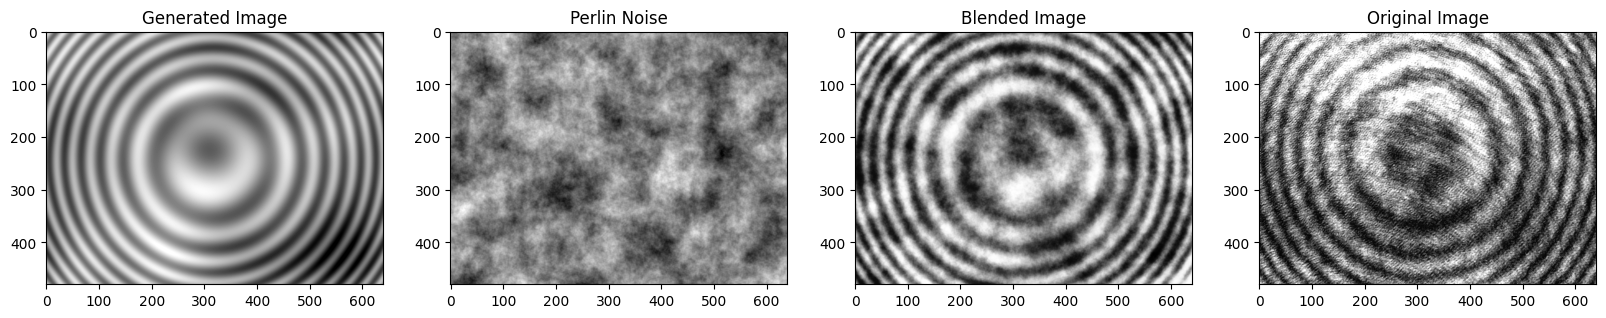

True

In [3]:
# Load the generated image
image_path = "../../data/generated/fourier/single/fourier_single_steel_02000.png"  # Replace with your actual path
generated_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# load original image
original_image_path = "../../data/raw/steel/1channel/00000.png"
original_image = cv2.imread(original_image_path, cv2.IMREAD_GRAYSCALE)

# Generate Perlin noise with the same dimensions as the image
perlin_noise = generate_perlin_noise(generated_image.shape[1], generated_image.shape[0])

# Blend the noise with the generated image (control the blending with alpha)
alpha = 0.45  # Adjust this value to control noise intensity
blended_image = cv2.addWeighted(generated_image, 1 - alpha, perlin_noise, alpha, 0)
blended_image = apply_clahe(blended_image, tile_grid_size=(4, 4), clip_limit=2.2)

# Display the results
plt.figure(figsize=(20, 10))
plt.subplot(1, 4, 1)
plt.title("Generated Image")
plt.imshow(generated_image, cmap='gray')
plt.subplot(1, 4, 2)
plt.title("Perlin Noise")
plt.imshow(perlin_noise, cmap='gray')
plt.subplot(1, 4, 3)
plt.title("Blended Image")
plt.imshow(blended_image, cmap='gray')
plt.subplot(1, 4, 4)
plt.title("Original Image")
plt.imshow(original_image, cmap='gray')
plt.show()

# Save the blended image
cv2.imwrite("../../data/generated_with_perlin_noise.png", blended_image)

In [139]:
import pandas as pd
from tqdm import tqdm

In [149]:
GRID_SIZES = [(2, 2), (4, 4), (8, 8), (16, 16)]
CLIP_RANGE = [1.5, 2.2]
PERSISTANCE_RANGE = [0.7, 0.9]

path_to_save = "../../data/generated/perlin/moved/"
avg_path = "../../data/generated/average/steel/moved/"
avg_params = pd.read_csv(avg_path + "moved_parameters.csv")
perlin_params = []

# take rows from 2500 to 5000
avg_params = avg_params.iloc[15000:22500]

counter = 15000
alpha = 0.45
# iterate the dataframe
for index, row in tqdm(avg_params.iterrows()):
    # load the image
    image_path = avg_path + row["filename"]
    generated_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    grid_size = random.choice(GRID_SIZES)
    clip_limit = random.uniform(1.0, 2.0)
    persistance = random.uniform(0.7, 0.9)

    perlin_noise = generate_perlin_noise(generated_image.shape[1], generated_image.shape[0], scale=100, octaves=6, persistence=persistance, lacunarity=2.0)

    blended_image = cv2.addWeighted(generated_image, 1 - alpha, perlin_noise, alpha, 0)
    blended_image = apply_clahe(blended_image, tile_grid_size=grid_size, clip_limit=clip_limit)
    blended_image = controller.generate(blended_image, row["epsilon"])
    filename = f"perlin_{counter:05d}.png"
    cv2.imwrite(path_to_save + filename, blended_image)

    perlin_params.append({
        "width": generated_image.shape[1],
        "height": generated_image.shape[0],
        "epsilon": row["epsilon"],
        "ring_center_width": row["ring_center_width"],
        "ring_center_height": row["ring_center_height"],
        "min_brightness": row["min_brightness"],
        "max_brightness": row["max_brightness"],
        "filename": filename,
        "grid_size": grid_size,
        "clip_limit": clip_limit,
        "persistance": persistance
    })

    counter += 1

df = pd.DataFrame(perlin_params)
df.to_csv(path_to_save + "parameters1.csv", index=False)


5000it [48:03,  1.73it/s]


KeyboardInterrupt: 

In [6]:
path_to_save = "../../data/generated/perlin/fourier/"
avg_path = "../../data/generated/fourier/single/"
avg_params = pd.read_csv(avg_path + "parameters.csv")
perlin_params = []

# take rows from 2500 to 5000
avg_params = avg_params.iloc[:2500]
avg_params

,width,height,epsilon,ring_center_width,ring_center_height,min_brightness,max_brightness,used_noise,filename
0,640,480,0.000,317,242,92,190,-1,fourier_single_steel_00000.png
1,640,480,0.000,319,240,86,199,-1,fourier_single_steel_00001.png
2,640,480,0.000,324,238,100,205,-1,fourier_single_steel_00002.png
3,640,480,0.000,320,241,81,198,-1,fourier_single_steel_00003.png
4,640,480,0.000,318,238,81,199,-1,fourier_single_steel_00004.png
...,...,...,...,...,...,...,...,...,...
2495,640,480,0.249,318,235,98,195,-1,fourier_single_steel_02495.png
2496,640,480,0.249,315,243,80,194,-1,fourier_single_steel_02496.png
2497,640,480,0.249,319,235,87,198,-1,fourier_single_steel_02497.png
2498,640,480,0.249,319,237,87,199,-1,fourier_single_steel_02498.png


In [154]:
perlin_params[-1]

{'width': 640,
 'height': 480,
 'epsilon': 0.5,
 'ring_center_width': 323,
 'ring_center_height': 242,
 'min_brightness': 96,
 'max_brightness': 192,
 'filename': 'perlin_15001.png',
 'grid_size': (16, 16),
 'clip_limit': 1.700820853857139,
 'persistance': 0.8150009915366965}

In [152]:
df = pd.DataFrame(perlin_params)
df.to_csv(path_to_save + "parameters.csv", index=False)